Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2021/2022
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Logistička regresija

*Verzija: 1.0 
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **7. studenog 2021. u 23:59h**

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od četiri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

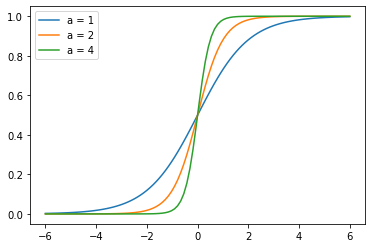

In [3]:
# Vaš kôd ovdje

alphas = [1,2,4]

def sigm(x,alpha = 1):
    
    return 1/(1+np.exp(-alpha*x))
    
X = np.linspace(-6,6,100)

for alpha in alphas:
    
    plt.plot(X,sigm(X,alpha))
    plt.legend(['a = 1','a = 2', 'a = 4'])
    


**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [4]:
from numpy import linalg
import numpy as np
from sklearn.preprocessing import PolynomialFeatures as PolyFeat

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    
    N = X.shape[0]
    D = X.shape[1]
    
    w_trace = []
    
    dummy = np.ones((N,1))

    w_tilda = np.zeros(D+1)
    
    for i in range(max_iter):
        
        w_0_grad = 0
        w_grad = np.zeros(D)
        error = 0
        
        for j in range(N):
            
            y_pred = lr_h(X[j],w_tilda)
            
            w_0_grad -= (y_pred-y[j])
            w_grad -= (y_pred-y[j])*X[j]
          
        
        w_tilda[0] += w_0_grad*eta

        w_tilda[1:] = w_tilda[1:]*(1-eta*alpha) + w_grad*eta
        
        w_trace.append(np.array(w_tilda))
        
        #error+=cross_entropy_error(X,y,w_tilda)   
    
    if(trace):
        
        return w_trace
    
    else:
        
        return w_tilda
    
def cross_entropy_error(X,y,w):
    
    N = X.shape[0]
    error = 0
    
    for i in range(N):
        
        y_pred = lr_h(X[i],w)
        error+=(-y[i]*np.log(y_pred)- (1 - y[i])*np.log(1-y_pred))
    
    return (1/N)*error
            
        
def lr_h(x,w):
    
    x_tilda = np.insert(x, 0, 1, axis=0)
    return sigm(x_tilda@w.T)
    
# X = np.array([[1,1],[3,4],[5,6]])
# y = np.array([1,1,1])
#w = lr_train(X,y,trace=True)
#print(w)
# w = np.array([1,2,3])
# dummy = np.ones((3,1))
# X_tilda = np.hstack((dummy,X))
# print(X_tilda)
# print(lr_h(X_tilda,w))
# print(cross_entropy_error(X,y,w))
# y_pred = lr_h(X_tilda,w)

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [5]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

[ 6.44150959 -2.11012128  0.53522851]
0.07751718252492557


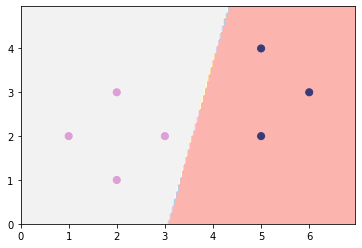

In [6]:
# Vaš kôd ovdje
w = lr_train(seven_X,seven_y,trace=False)
dummy = np.ones((7,1))
X_tilda = np.hstack((dummy,seven_X))

print(w)
print(cross_entropy_error(seven_X,seven_y,w))

h = lambda x: lr_h(x,w) > 0.5

plot_2d_clf_problem(seven_X, seven_y, h=h)


**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

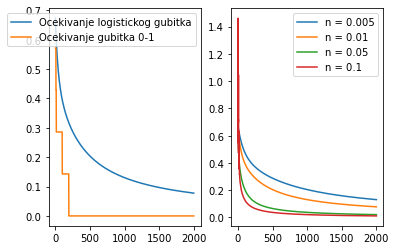

In [7]:
from sklearn.metrics import zero_one_loss

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.figsize=(70,70)


w_stack = lr_train(seven_X,seven_y,trace=True)

E_cross = []
E_zero_one = []

etas = np.array([0.005,0.01,0.05,0.1])

for w in w_stack:
    
    error = cross_entropy_error(seven_X,seven_y,w)
    E_cross.append(error)

    y_pred = [lr_h(x,w)>=0.5 for x in seven_X]
    loss = zero_one_loss(seven_y, y_pred)
    E_zero_one.append(loss)

ax1.plot([i for i in range(0,len(w_stack))],E_cross)
ax1.plot([i for i in range(0,len(w_stack))],E_zero_one)
ax1.legend(["Ocekivanje logistickog gubitka","Ocekivanje gubitka 0-1"])

for eta in etas:
    
    E_cross = []
    E_zero_one = []
    w_stack = lr_train(seven_X,seven_y,trace=True,eta=eta)
    
    for w in w_stack:
    
        error = cross_entropy_error(seven_X,seven_y,w)
        E_cross.append(error)

        y_pred = [lr_h(x,w)>=0.5 for x in seven_X]
        loss = zero_one_loss(seven_y, y_pred)
        E_zero_one.append(loss)
  
    ax2.plot([i for i in range(0,len(w_stack))],E_cross)
    ax2.legend(["n = "+str(e) for e in etas])


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

[[34.46329289 -7.9307128  -1.37398685]]


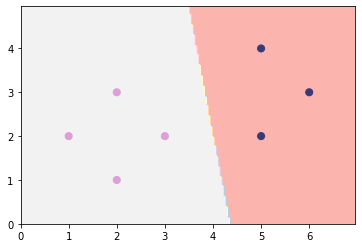

In [8]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state = 0,max_iter=2000, tol=0.0001, C = 10000).fit(seven_X, seven_y)
w = clf.coef_
w = np.insert(w, 0, clf.intercept_, axis=1)
print(w)
clf.predict(seven_X)
clf.score(seven_X, seven_y)
# Vaš kôd ovdje

h = lambda x: clf.predict(x) > 0.5

plot_2d_clf_problem(seven_X, seven_y, h=h)

### 2. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [9]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

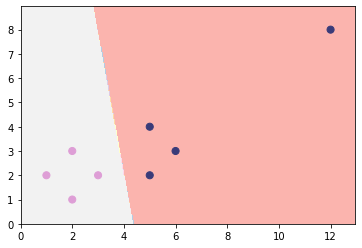

In [10]:
# Vaš kôd ovdje
w = lr_train(outlier_X,outlier_y,trace=False)
h = lambda x: clf.predict(x) > 0.5
plot_2d_clf_problem(outlier_X, outlier_y, h=h)

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

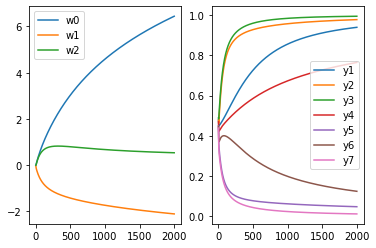

In [11]:
# Vaš kôd ovdje
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.figsize=(25, 25)

w_stack = lr_train(seven_X,seven_y,trace=True)
predictions = []

for w in w_stack:
    
    y_pred = []
    for x in seven_X:
        
        y_pred.append(lr_h(x,w))
    predictions.append(y_pred)

ax1.plot([i for i in range(len(w_stack))],[w for w in w_stack])
ax1.legend(["w0","w1","w2"])

ax2.plot([i for i in range(len(predictions))], [y_pred for y_pred in predictions])
ax2.legend(["y"+str(i) for i in range(1,8)])

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [12]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

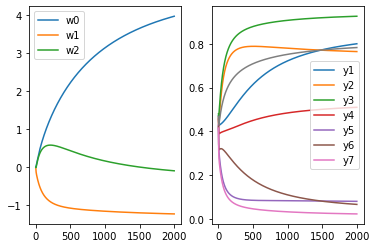

In [13]:
# Vaš kôd ovdje
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.figsize=(25, 25)

w_stack = lr_train(unsep_X,unsep_y,trace=True)
predictions = []

for w in w_stack:
    
    y_pred = []
    for x in unsep_X:
        
        y_pred.append(lr_h(x,w))
    predictions.append(y_pred)

ax1.plot([i for i in range(len(w_stack))],[w for w in w_stack])
ax1.legend(["w0","w1","w2"])

ax2.plot([i for i in range(len(predictions))], [y_pred for y_pred in predictions])
ax2.legend(["y"+str(i) for i in range(1,8)])

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 3. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

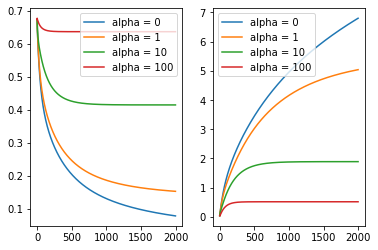

In [14]:
from numpy.linalg import norm

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.figsize=(25, 25)

alphas = np.array([0,1,10,100])

for alpha in alphas:
    
    E_cross = []
    norms = []
    w_stack = lr_train(seven_X,seven_y,trace=True,alpha = alpha)
    
    for w in w_stack:

        error = cross_entropy_error(seven_X,seven_y,w)
        E_cross.append(error)
        
        n = norm(w, 2)
        norms.append(n)
        
    ax1.plot([i for i in range(len(E_cross))], E_cross)
    ax1.legend(["alpha = 0","alpha = 1","alpha = 10","alpha = 100"])
    
    ax2.plot([i for i in range(len(norms))], norms)
    ax2.legend(["alpha = 0","alpha = 1","alpha = 10","alpha = 100"])
    

In [15]:
# Vaš kôd ovdje

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 4. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

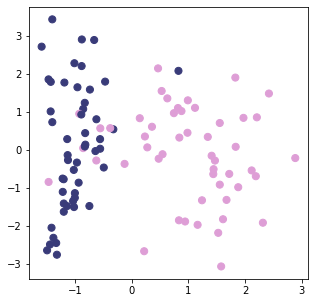

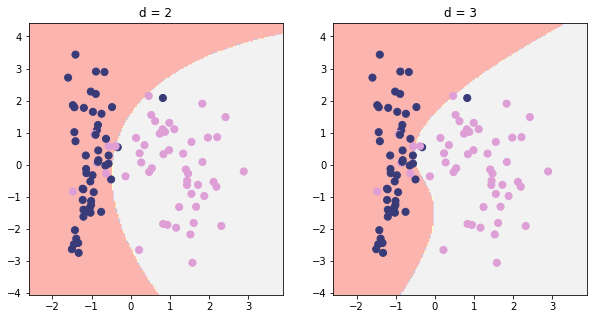

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

X,Y_ = make_classification(n_samples=100,n_classes=2,n_clusters_per_class=2,n_features=2,n_redundant=0)

figure(figsize(5, 5))
plot_2d_clf_problem(X, Y_)

ds = [2,3]
figure(figsize(10, 5))

for i in range(len(ds)):
    
    subplot(1,2,i+1)
    
    poly = PolynomialFeatures(ds[i])
    X_transformed = poly.fit_transform(X)
    
    model = LogisticRegression(C=1)
    model.fit(X_transformed, Y_)
    
    h = lambda x : model.predict(poly.transform(x))

    plot_2d_clf_problem(X, Y_, h)
    title('d = ' + str(ds[i]))

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?